In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import networkx as nx
from collections import defaultdict


In [2]:
access_data = pd.read_csv('Accessibility.csv')
print("Access data loaded:", access_data.shape)

employee_data = pd.read_csv('Employees_table.csv')
employee_data['Access_ID'] = employee_data['Access_ID'].apply(ast.literal_eval)
print("Employee data loaded:", employee_data.shape)

department_data = pd.read_csv('Department.csv')
print("Department data loaded:", department_data.shape)

Access data loaded: (28, 2)
Employee data loaded: (36, 3)
Department data loaded: (13, 2)


In [3]:
employee_data = employee_data.merge(department_data, on='Dept_ID', how='left')
print("\nEmployees with department names:")
print(employee_data.head())


Employees with department names:
          Emp_name  Dept_ID            Access_ID             Dept_Name
0   Ajay Chhajlani        1  [1, 2, 3, 4, 9, 16]  Accounts and Finance
1       Amar Gupta        1  [1, 2, 3, 4, 9, 16]  Accounts and Finance
2     Amit Bansode        1  [1, 2, 3, 4, 9, 16]  Accounts and Finance
3     Aniket Khode        1  [1, 2, 3, 4, 9, 16]  Accounts and Finance
4  Kajal Prajapati        1  [1, 2, 3, 4, 9, 16]  Accounts and Finance


In [5]:
access_risk_weights = {
    1: 1,  # Teams - low risk
    2: 2,  # Outlook_Internal
    3: 5,  # Outlook_External - higher risk (external communication)
    4: 2,  # Outlook_Internal_Dept
    5: 7,  # Gmail - high risk (external personal email)
    6: 7,  # Whatsapp - high risk (external messaging)
    7: 3,  # Survey_Genius
    8: 4,  # SD_IT_Analytics
    9: 8,  # SD_Cyberdata - very high risk (security data)
    10: 4,  # SD_Quality_Daily_Reports
    11: 5,  # SD_Data_Analytics
    12: 6,  # SD_Mahindra
    13: 4,  # SD_Daily_Lat_long
    14: 4,  # SD_Daily_Reports
    15: 6,  # SD_HR_Common - sensitive HR data
    16: 7,  # SD_Accounts_HO - sensitive financial data
    17: 5,  # SD_Operations
    18: 4,  # SD_Training_L&D
    19: 4,  # SD_Quality
    20: 6,  # SD_CRIS
    21: 7,  # SD_Govt_Projects - sensitive government data
    22: 7,  # SD_CMI_Partnership
    23: 3,  # SD_Designer
    24: 3,  # SD_Researcher
    25: 2,  # DTP
    26: 5,  # AMI Projects
    27: 4,  # SD_Marketing
    28: 10  # Full_access - highest risk
}

# Group access types into functional categories for better scenario identification
access_categories = {
    'external_comm': [3, 5, 6],  # External communication channels
    'sensitive_data': [9, 15, 16, 21, 22],  # Highly sensitive data
    'analytics': [8, 10, 11, 13, 14],  # Analytics and reporting tools
    'operational': [12, 17, 19, 20],  # Operational systems
    'design_research': [23, 24, 25, 27],  # Design and research tools
    'project_specific': [7, 18, 26],  # Project-specific tools
    'super_access': [28]  # Full access
}


C:\Users\adity\AppData\Local\Temp\ipykernel_28884\3522995121.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=access_df, x='AccessID', y='RiskWeight', palette='viridis')


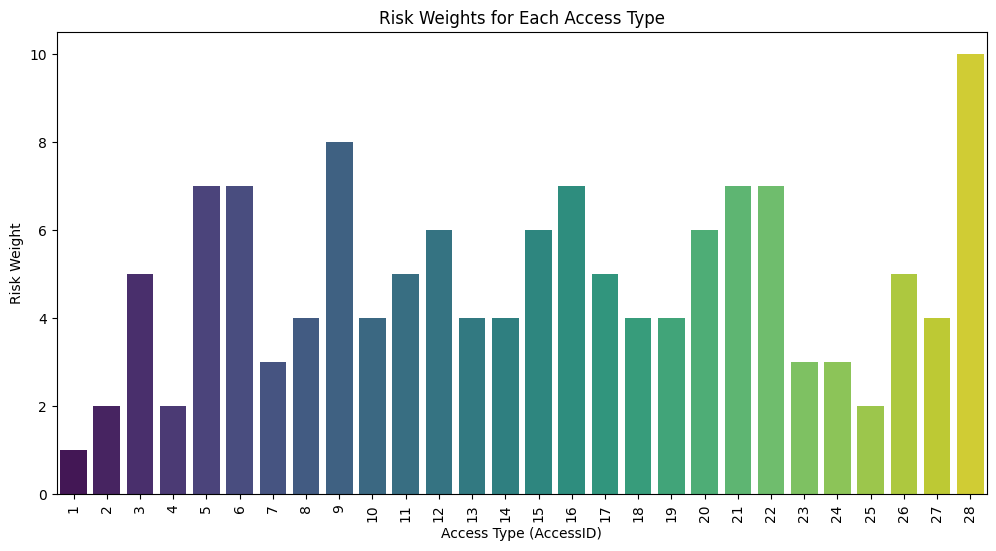

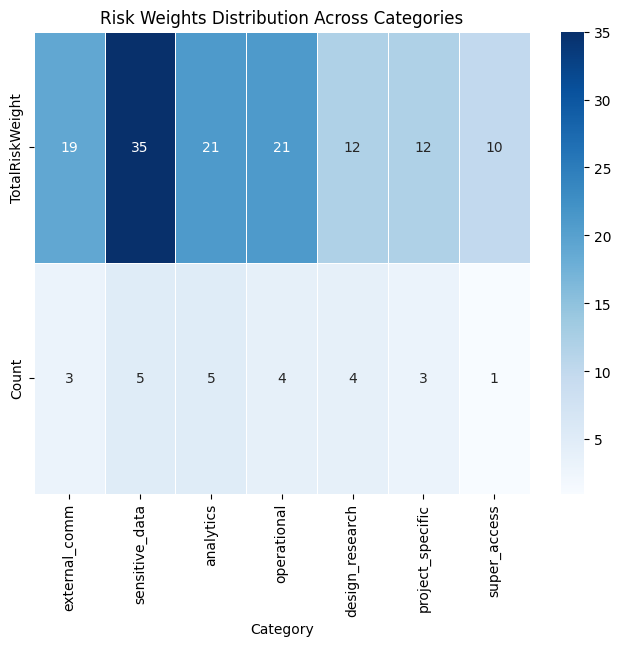

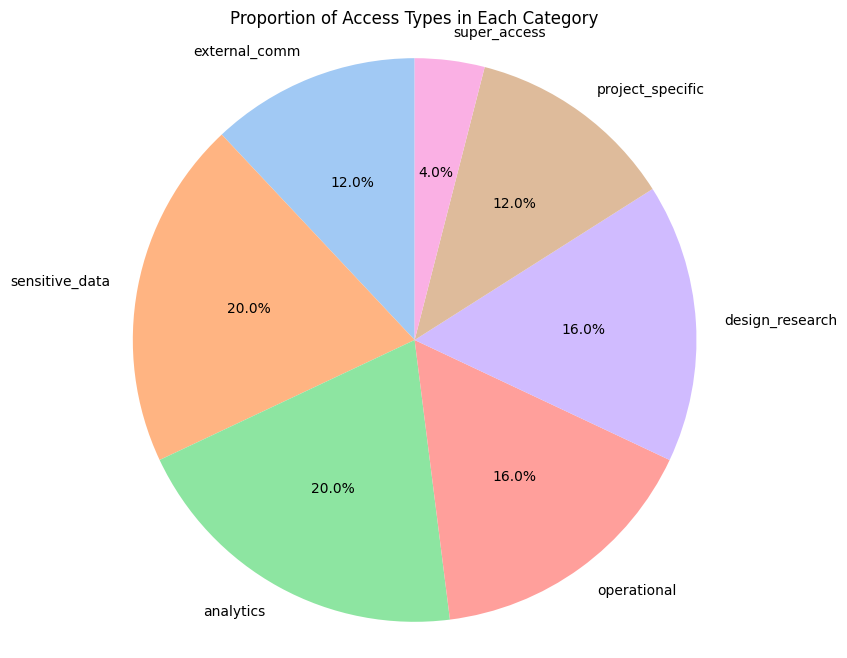

In [16]:
access_df = pd.DataFrame(list(access_risk_weights.items()), columns=['AccessID', 'RiskWeight'])

# Add Category column based on access_categories mapping
def get_category(access_id):
    for category, ids in access_categories.items():
        if access_id in ids:
            return category
    return 'uncategorized'  # For access types not in any category

access_df['Category'] = access_df['AccessID'].apply(get_category)

# Step 3: Plotting Bar Chart for Risk Weights of Each Access Type
plt.figure(figsize=(12, 6))
sns.barplot(data=access_df, x='AccessID', y='RiskWeight', palette='viridis')
plt.title('Risk Weights for Each Access Type')
plt.xlabel('Access Type (AccessID)')
plt.ylabel('Risk Weight')
plt.xticks(rotation=90)
plt.show()

# Step 4: Heatmap to show distribution of access types across categories
category_counts = {cat: len(ids) for cat, ids in access_categories.items()}
risk_weights_per_category = {cat: sum([access_risk_weights[aid] for aid in ids]) for cat, ids in access_categories.items()}

category_df = pd.DataFrame(list(risk_weights_per_category.items()), columns=['Category', 'TotalRiskWeight'])
category_df['Count'] = category_df['Category'].apply(lambda x: category_counts[x])

# Plotting Heatmap
category_df.set_index('Category', inplace=True)  # Set 'Category' as index
plt.figure(figsize=(8, 6))
sns.heatmap(category_df.T, annot=True, cmap='Blues', cbar=True, linewidths=0.5)
plt.title('Risk Weights Distribution Across Categories')
plt.show()

# Step 5: Pie Chart for the Proportion of Each Category
category_sizes = category_df['Count'].values
category_labels = category_df.index

plt.figure(figsize=(8, 8))
plt.pie(category_sizes, labels=category_labels, autopct='%1.1f%%', colors=sns.color_palette('pastel', len(category_labels)), startangle=90)
plt.title('Proportion of Access Types in Each Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [7]:
def calculate_risk_score(access_list):
    base_score = sum(access_risk_weights.get(access_id, 0) for access_id in access_list)
    
    # Example: External communication tools + sensitive data access
    has_external_comm = any(access_id in access_categories['external_comm'] for access_id in access_list)
    has_sensitive_data = any(access_id in access_categories['sensitive_data'] for access_id in access_list)
    has_analytics = any(access_id in access_categories['analytics'] for access_id in access_list)
    has_full_access = any(access_id in access_categories['super_access'] for access_id in access_list)
    
    combo_risk = 0
    if has_external_comm and has_sensitive_data:
        combo_risk += 15  # High risk combo: external comm + sensitive data
    if has_full_access and has_external_comm:
        combo_risk += 25  # Very high risk: full access + external communication
    if has_sensitive_data and has_analytics:
        combo_risk += 10  # Risky: Can analyze sensitive data and potentially extract insights
    if has_external_comm and has_analytics and has_sensitive_data:
        combo_risk += 20  # Very high risk: Can analyze, access sensitive data and send externally
        
    return base_score + combo_risk

In [8]:
employee_data['Risk_Score'] = employee_data['Access_ID'].apply(calculate_risk_score)

In [9]:
dept_avg_risk = employee_data.groupby('Dept_Name')['Risk_Score'].mean().reset_index()
dept_avg_risk = dept_avg_risk.rename(columns={'Risk_Score': 'Avg_Dept_Risk'})

In [10]:
employee_data = employee_data.merge(dept_avg_risk, on='Dept_Name', how='left')
employee_data['Risk_Deviation'] = employee_data['Risk_Score'] - employee_data['Avg_Dept_Risk']


In [11]:
def identify_breach_pathways(employee):
    """Identify specific data breach scenarios based on access combinations"""
    pathways = []
    scenarios = []
    access_ids = employee['Access_ID']
    
    # Check employee's access against our defined categories
    has_access = {}
    for category, id_list in access_categories.items():
        has_access[category] = any(id in access_ids for id in id_list)
    
    # PATHWAY ANALYSIS
    # ----------------
    
    # Pathway 1: External email + sensitive data
    if has_access['external_comm'] and has_access['sensitive_data']:
        pathways.append("External Email → Sensitive Data")
        
        # Add specific breach scenarios based on which sensitive systems they can access
        if 9 in access_ids:  # SD_Cyberdata
            scenarios.append("Could exfiltrate security data via external email")
        if 16 in access_ids:  # SD_Accounts_HO
            scenarios.append("Could leak financial data through personal communication channels")
        if 21 in access_ids:  # SD_Govt_Projects
            scenarios.append("Government project data at risk of external exposure")
    
    # Pathway 2: Full access + external communication
    if has_access['super_access'] and has_access['external_comm']:
        pathways.append("Full System Access → External Communication")
        scenarios.append("Has unrestricted data access with external communication channels")
        
        # Check for specific high-risk external channels
        if 5 in access_ids:  # Gmail
            scenarios.append("Could send company data to personal Gmail account")
        if 6 in access_ids:  # WhatsApp
            scenarios.append("WhatsApp presents unmonitored communication channel for sensitive data")
    
    # Pathway 3: Access to multiple departments' data
    dept_specific = [access for access in access_ids if access >= 10 and access < 28]
    if len(dept_specific) >= 3:
        pathways.append("Cross-Department Data Access")
        scenarios.append(f"Has access to {len(dept_specific)} department-specific systems")
        
        # High risk: Cross-department access + external comm
        if has_access['external_comm']:
            scenarios.append("Can correlate data across departments and send externally")
    
    # Pathway 4: Financial data + external communication
    if 16 in access_ids and has_access['external_comm']:
        pathways.append("Financial Data → External Communication")
        scenarios.append("Financial data could be exfiltrated through external channels")
    
    # NEW PATHWAY 5: Analytics tools + sensitive data + external comm
    if has_access['analytics'] and has_access['sensitive_data'] and has_access['external_comm']:
        pathways.append("Analytics → Sensitive Data → External Communication")
        scenarios.append("Could analyze sensitive data and exfiltrate insights")
        
        # Specific high-risk analytics scenarios
        if 11 in access_ids:  # SD_Data_Analytics
            scenarios.append("Data analytics tools could be used to identify high-value information")
    
    # NEW PATHWAY 6: Cross-function access (IT + Finance)
    if 8 in access_ids and 16 in access_ids:  # IT Analytics + Financial data
        pathways.append("IT Analytics → Financial Data")
        scenarios.append("Technical skills combined with financial data access creates fraud risk")
    
    # NEW PATHWAY 7: HR data exposure
    if 15 in access_ids and has_access['external_comm']:
        pathways.append("HR Data → External Communication")
        scenarios.append("Employee personal data could be leaked externally")
    
    # NEW PATHWAY 8: Competitor intelligence risk
    if has_access['design_research'] and has_access['external_comm'] and has_access['project_specific']:
        pathways.append("Research & Design → External Communication")
        scenarios.append("Intellectual property/design research could leak to competitors")
    
    # NEW PATHWAY 9: Multi-platform external communication risk
    external_channels = [id for id in access_ids if id in [3, 5, 6]]
    if len(external_channels) >= 2:
        pathways.append("Multiple External Communication Channels")
        scenarios.append(f"Uses {len(external_channels)} different external communication methods, complicating monitoring")
    
    # NEW PATHWAY 10: Supply chain risk
    if 12 in access_ids and has_access['external_comm']:  # SD_Mahindra + external comm
        pathways.append("Supply Chain Data → External Communication")
        scenarios.append("Vendor/supply chain data could be leaked to competitors")
    
    return pathways, scenarios

# Apply the function to identify breach pathways and scenarios
breach_analysis = employee_data.apply(
    lambda emp: pd.Series(identify_breach_pathways(emp), index=['Breach_Pathways', 'Breach_Scenarios']), 
    axis=1
)
employee_data = pd.concat([employee_data, breach_analysis], axis=1)
employee_data['Num_Pathways'] = employee_data['Breach_Pathways'].apply(len)
employee_data['Num_Scenarios'] = employee_data['Breach_Scenarios'].apply(len)

In [12]:
print("\n=== ENHANCED SECURITY RISK ANALYSIS REPORT ===")

# Top 5 highest risk employees
print("\nTop 5 Highest Risk Employees:")
high_risk_employees = employee_data.sort_values('Risk_Score', ascending=False).head(5)
for _, row in high_risk_employees.iterrows():
    print(f"{row['Emp_name']} (Dept: {row['Dept_Name']}) - Risk Score: {row['Risk_Score']}")
    print(f"  Access Count: {len(row['Access_ID'])}")
    print(f"  Potential Breach Pathways:")
    for pathway in row['Breach_Pathways']:
        print(f"    - {pathway}")
    print(f"  Breach Scenarios:")
    for scenario in row['Breach_Scenarios']:
        print(f"    - {scenario}")
    print()

# Department risk summary
print("\nDepartment Risk Summary:")
dept_risk = employee_data.groupby('Dept_Name').agg({
    'Risk_Score': ['mean', 'max', 'count'],
    'Num_Pathways': 'sum',
    'Num_Scenarios': 'sum'
}).reset_index()
dept_risk.columns = ['Department', 'Avg_Risk', 'Max_Risk', 'Employee_Count', 'Total_Breach_Pathways', 'Total_Breach_Scenarios']
print(dept_risk.sort_values('Avg_Risk', ascending=False))



=== ENHANCED SECURITY RISK ANALYSIS REPORT ===

Top 5 Highest Risk Employees:
Sebastian Narlia (Dept: DTP) - Risk Score: 128
  Access Count: 12
  Potential Breach Pathways:
    - External Email → Sensitive Data
    - Full System Access → External Communication
    - Cross-Department Data Access
    - Analytics → Sensitive Data → External Communication
    - Research & Design → External Communication
    - Multiple External Communication Channels
    - Supply Chain Data → External Communication
  Breach Scenarios:
    - Could exfiltrate security data via external email
    - Has unrestricted data access with external communication channels
    - Could send company data to personal Gmail account
    - WhatsApp presents unmonitored communication channel for sensitive data
    - Has access to 4 department-specific systems
    - Can correlate data across departments and send externally
    - Could analyze sensitive data and exfiltrate insights
    - Intellectual property/design research co

In [13]:
# 7. Detailed Breach Scenario Analysis
# ===================================
print("\n=== DETAILED BREACH SCENARIO ANALYSIS ===")

# Count occurrences of each breach pathway
pathway_counts = defaultdict(int)
for pathways in employee_data['Breach_Pathways']:
    for path in pathways:
        pathway_counts[path] += 1

# Sort and display most common breach pathways
print("\nMost Common Breach Pathways:")
for pathway, count in sorted(pathway_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{pathway}: {count} employees")

# Count occurrences of each breach scenario
scenario_counts = defaultdict(int)
for scenarios in employee_data['Breach_Scenarios']:
    for scenario in scenarios:
        scenario_counts[scenario] += 1

# Sort and display most common breach scenarios
print("\nMost Common Breach Scenarios:")
for scenario, count in sorted(scenario_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{scenario}: {count} employees")


=== DETAILED BREACH SCENARIO ANALYSIS ===

Most Common Breach Pathways:
External Email → Sensitive Data: 18 employees
Financial Data → External Communication: 10 employees
Full System Access → External Communication: 7 employees
Multiple External Communication Channels: 6 employees
Cross-Department Data Access: 5 employees
HR Data → External Communication: 1 employees
Analytics → Sensitive Data → External Communication: 1 employees
Research & Design → External Communication: 1 employees
Supply Chain Data → External Communication: 1 employees

Most Common Breach Scenarios:
Could exfiltrate security data via external email: 18 employees
Could leak financial data through personal communication channels: 10 employees
Financial data could be exfiltrated through external channels: 10 employees
Has unrestricted data access with external communication channels: 7 employees
Could send company data to personal Gmail account: 7 employees
WhatsApp presents unmonitored communication channel for se


=== CROSS-DEPARTMENTAL RISK ANALYSIS ===

Found 5 employees with cross-department access:
Nikhil Shah (CMI and Partnership) - Access to 3 department systems
  Department systems: SD_CRIS, SD_Govt_Projects, SD_CMI_Partnership
Vishal Kamath (CMI and Partnership) - Access to 3 department systems
  Department systems: SD_CRIS, SD_Govt_Projects, SD_CMI_Partnership
Ashwin Borse (Data Analytics) - Access to 3 department systems
  Department systems: SD_Data_Analytics, SD_Mahindra, SD_Daily_Reports
Uday Pawar (Data Analytics) - Access to 3 department systems
  Department systems: SD_Quality_Daily_Reports, SD_Data_Analytics, SD_Daily_Reports
Sebastian Narlia (DTP) - Access to 4 department systems
  Department systems: SD_Mahindra, DTP, AMI Projects, SD_Marketing

=== DATA EXFILTRATION PATH ANALYSIS ===

Found 18 employees with data exfiltration risk:

CRITICAL Exfiltration Risk (7 employees):
  Mellisa Dsilva (CMD's Office) - Risk Score: 85
    External channels: Outlook_External, Gmail, Whats

C:\Users\adity\AppData\Local\Temp\ipykernel_28884\3034719781.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exfil_risk['Exfil_Risk'] = exfil_risk.apply(


UnicodeEncodeError: 'charmap' codec can't encode character '\u2192' in position 19: character maps to <undefined>

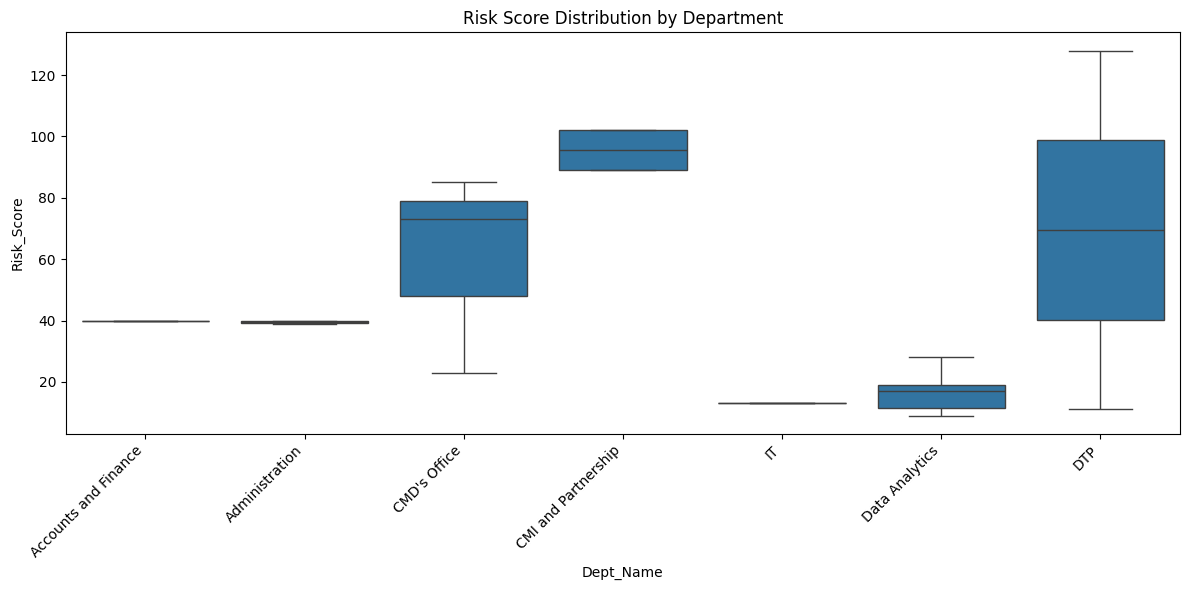

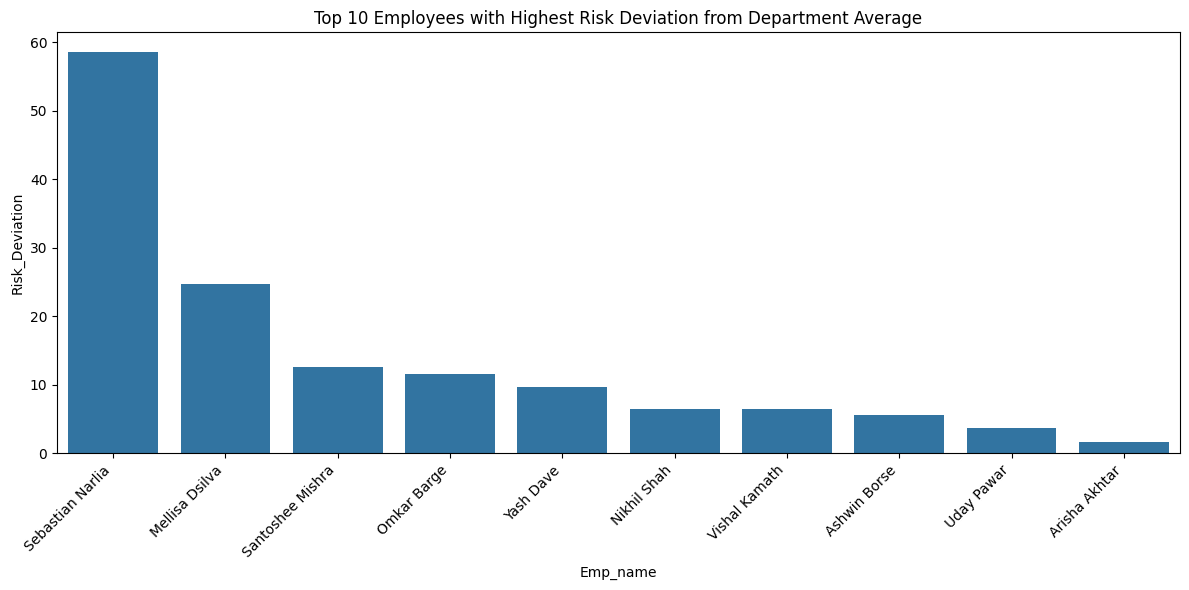

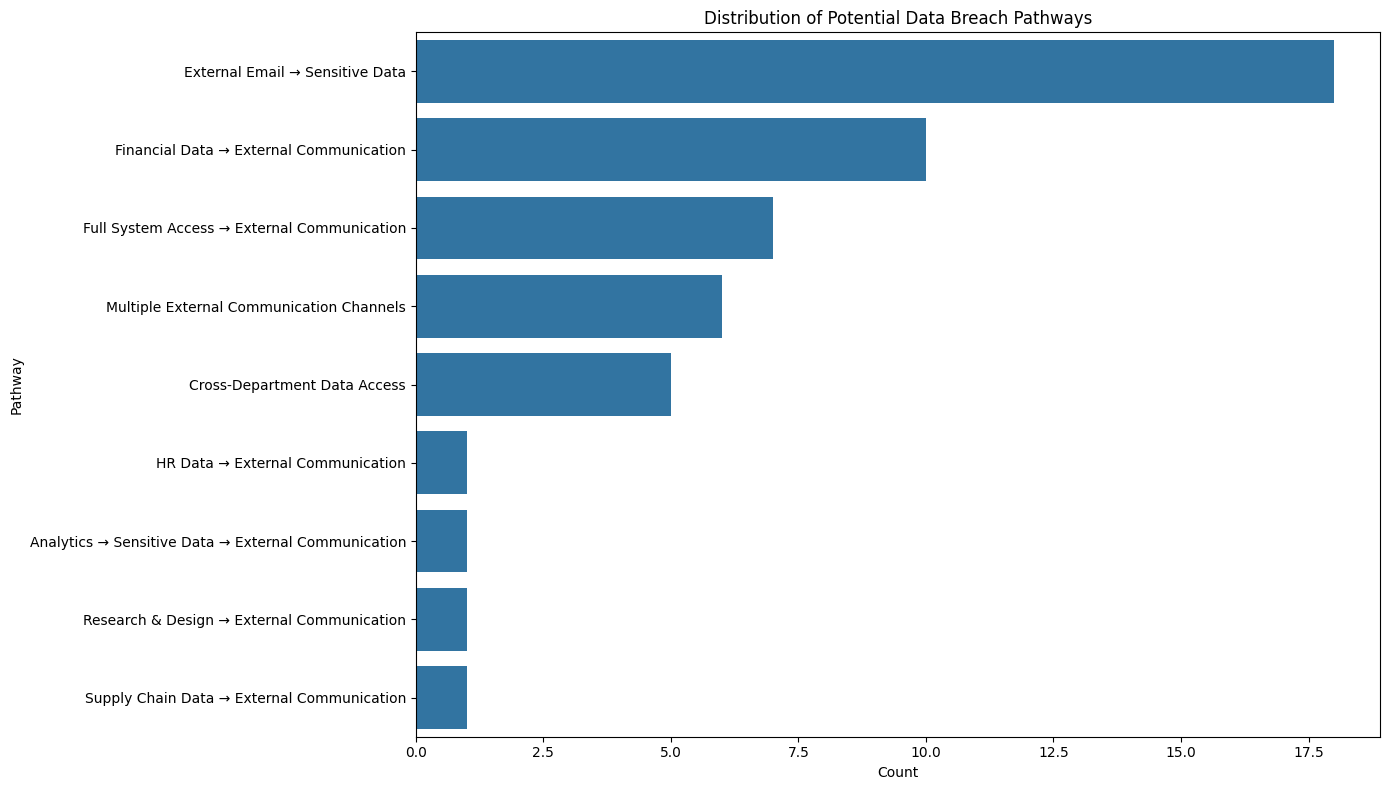

In [14]:

# 8. Cross-departmental Risk Analysis
print("\n=== CROSS-DEPARTMENTAL RISK ANALYSIS ===")

# Employees with access across multiple departments
cross_dept_employees = employee_data[employee_data['Breach_Pathways'].apply(
    lambda paths: "Cross-Department Data Access" in paths if paths else False
)]

if not cross_dept_employees.empty:
    print(f"\nFound {len(cross_dept_employees)} employees with cross-department access:")
    for _, emp in cross_dept_employees.iterrows():
        dept_systems = [id for id in emp['Access_ID'] if id >= 10 and id < 28]
        print(f"{emp['Emp_name']} ({emp['Dept_Name']}) - Access to {len(dept_systems)} department systems")
        # Show which department systems they access
        dept_access = []
        for access_id in dept_systems:
            access_name = next((row['Access'] for _, row in access_data.iterrows() 
                               if row['Access_ID'] == access_id), f"Access_{access_id}")
            dept_access.append(access_name)
        print(f"  Department systems: {', '.join(dept_access)}")
else:
    print("No employees with significant cross-departmental access found.")

# 9. Data Exfiltration Path Analysis
# ================================
print("\n=== DATA EXFILTRATION PATH ANALYSIS ===")

# Focus on employees with both sensitive data access and external communication channels
exfil_risk = employee_data[employee_data['Breach_Pathways'].apply(
    lambda paths: any("External" in path for path in paths) if paths else False
)]

if not exfil_risk.empty:
    print(f"\nFound {len(exfil_risk)} employees with data exfiltration risk:")
    
    # Categorize by exfiltration risk level
    exfil_risk['Exfil_Risk'] = exfil_risk.apply(
        lambda emp: "CRITICAL" if "Full System Access → External Communication" in emp['Breach_Pathways'] 
                   else "HIGH" if "Analytics → Sensitive Data → External Communication" in emp['Breach_Pathways']
                   else "MEDIUM" if "Financial Data → External Communication" in emp['Breach_Pathways']
                   else "LOW",
        axis=1
    )
    
    # Display by risk category
    for risk_level in ["CRITICAL", "HIGH", "MEDIUM", "LOW"]:
        risk_group = exfil_risk[exfil_risk['Exfil_Risk'] == risk_level]
        if not risk_group.empty:
            print(f"\n{risk_level} Exfiltration Risk ({len(risk_group)} employees):")
            for _, emp in risk_group.iterrows():
                print(f"  {emp['Emp_name']} ({emp['Dept_Name']}) - Risk Score: {emp['Risk_Score']}")
                # Show external channels they have access to
                ext_channels = []
                for access_id in emp['Access_ID']:
                    if access_id in [3, 5, 6]:  # External communication channels
                        access_name = next((row['Access'] for _, row in access_data.iterrows() 
                                        if row['Access_ID'] == access_id), f"Access_{access_id}")
                        ext_channels.append(access_name)
                print(f"    External channels: {', '.join(ext_channels)}")
else:
    print("No employees with significant data exfiltration risk found.")

# 10. Visualize the results
# =======================
# Plot risk scores by department
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dept_Name', y='Risk_Score', data=employee_data)
plt.xticks(rotation=45, ha='right')
plt.title('Risk Score Distribution by Department')
plt.tight_layout()
plt.savefig('risk_by_department.png')

# Plot employees with highest risk deviation
top_deviations = employee_data.sort_values('Risk_Deviation', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Emp_name', y='Risk_Deviation', data=top_deviations)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Employees with Highest Risk Deviation from Department Average')
plt.tight_layout()
plt.savefig('risk_deviation.png')

# Plot breach pathway distribution
pathway_df = pd.DataFrame([(path, count) for path, count in pathway_counts.items()], 
                         columns=['Pathway', 'Count'])
pathway_df = pathway_df.sort_values('Count', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x='Count', y='Pathway', data=pathway_df)
plt.title('Distribution of Potential Data Breach Pathways')
plt.tight_layout()
plt.savefig('breach_pathways.png')

# 11. Save detailed risk report
# ===========================
with open('enhanced_security_risk_report.txt', 'w') as f:
    f.write("ENHANCED SECURITY RISK REPORT\n")
    f.write("=============================\n\n")
    
    # Summary statistics
    f.write("SUMMARY STATISTICS\n")
    f.write("-----------------\n")
    f.write(f"Total employees analyzed: {len(employee_data)}\n")
    f.write(f"Employees with at least one breach pathway: {len(employee_data[employee_data['Num_Pathways'] > 0])}\n")
    f.write(f"Employees with critical exfiltration risk: {len(exfil_risk[exfil_risk['Exfil_Risk'] == 'CRITICAL']) if 'exfil_risk' in locals() else 'N/A'}\n")
    f.write(f"Total potential breach scenarios identified: {sum(employee_data['Num_Scenarios'])}\n\n")
    
    # Department risk ranking
    f.write("DEPARTMENT RISK RANKING\n")
    f.write("----------------------\n")
    for _, dept in dept_risk.sort_values('Avg_Risk', ascending=False).iterrows():
        f.write(f"{dept['Department']}: Avg Risk = {dept['Avg_Risk']:.2f}, Max Risk = {dept['Max_Risk']}, "
                f"Breach Pathways = {dept['Total_Breach_Pathways']}, Scenarios = {dept['Total_Breach_Scenarios']}\n")
    f.write("\n")
    
    # Top 10 highest risk employees
    f.write("TOP 10 HIGHEST RISK EMPLOYEES\n")
    f.write("--------------------------\n")
    top_risk = employee_data.sort_values('Risk_Score', ascending=False).head(10)
    for _, emp in top_risk.iterrows():
        f.write(f"Employee: {emp['Emp_name']} (Department: {emp['Dept_Name']})\n")
        f.write(f"Risk Score: {emp['Risk_Score']} (Department Avg: {emp['Avg_Dept_Risk']:.2f})\n")
        f.write(f"Access IDs: {emp['Access_ID']}\n")
        f.write("Potential Breach Pathways:\n")
        for pathway in emp['Breach_Pathways']:
            f.write(f"  - {pathway}\n")
        f.write("Breach Scenarios:\n")
        for scenario in emp['Breach_Scenarios']:
            f.write(f"  - {scenario}\n")
        f.write("\n")
    
    # Most common breach scenarios
    f.write("MOST COMMON BREACH SCENARIOS\n")
    f.write("---------------------------\n")
    for scenario, count in sorted(scenario_counts.items(), key=lambda x: x[1], reverse=True):
        f.write(f"{scenario}: {count} employees\n")
    f.write("\n")
    
    # Detailed employee breach profiles
    f.write("DETAILED EMPLOYEE BREACH PROFILES\n")
    f.write("-------------------------------\n")
    high_risk_emps = employee_data[employee_data['Num_Pathways'] > 0].sort_values('Risk_Score', ascending=False)
    
    for _, emp in high_risk_emps.iterrows():
        f.write(f"Employee: {emp['Emp_name']} (Department: {emp['Dept_Name']})\n")
        f.write(f"Risk Score: {emp['Risk_Score']} (Department Avg: {emp['Avg_Dept_Risk']:.2f})\n")
        
        # List all access rights with names
        f.write("Access Rights:\n")
        for access_id in emp['Access_ID']:
            access_name = next((row['Access'] for _, row in access_data.iterrows() 
                              if row['Access_ID'] == access_id), f"Access_{access_id}")
            f.write(f"  - {access_id}: {access_name}\n")
        
        f.write("Potential Breach Pathways:\n")
        for pathway in emp['Breach_Pathways']:
            f.write(f"  - {pathway}\n")
            
        f.write("Breach Scenarios:\n")
        for scenario in emp['Breach_Scenarios']:
            f.write(f"  - {scenario}\n")
        f.write("\n")

print("\nEnhanced Analysis complete. Results saved to:")
print("- risk_by_department.png")
print("- risk_deviation.png")
print("- breach_pathways.png")
print("- enhanced_security_risk_report.txt")

# 12. Recommendations based on findings
# ==================================
print("\n=== SECURITY RECOMMENDATIONS ===")
print("1. Review access rights for employees with high risk scores, especially those with multiple breach pathways")
print("2. Implement additional monitoring for external communications from high-risk employees")
print("3. Consider department-specific access policies where average risk scores are high")
print("4. Audit all employees with 'Full_access' rights to ensure necessity")
print("5. Implement separation of duties for employees with access to both sensitive data and external communication channels")
print("6. Implement data loss prevention (DLP) solutions focused on external communication channels")
print("7. Create role-based access control aligned with department needs")
print("8. Develop an incident response plan specific to data exfiltration scenarios")
print("9. Conduct regular security awareness training focused on data handling procedures")
print("10. Implement just-in-time access for sensitive systems instead of permanent access")

new

In [18]:
# Step 1.1: Load employee and department data
import pandas as pd
import ast  # for safely parsing Access_ID lists

# Load CSVs
employee_df = pd.read_csv("Employees_table.csv")
department_df = pd.read_csv("Department.csv")

# Convert string list in 'Access_ID' to actual list
employee_df["Access_ID"] = employee_df["Access_ID"].apply(ast.literal_eval)

# Merge with department names
merged_df = employee_df.merge(department_df, on="Dept_ID", how="left")

# Display the cleaned and merged data
merged_df.head()


,Emp_name,Dept_ID,Access_ID,Dept_Name
0,Ajay Chhajlani,1,"[1, 2, 3, 4, 9, 16]",Accounts and Finance
1,Amar Gupta,1,"[1, 2, 3, 4, 9, 16]",Accounts and Finance
2,Amit Bansode,1,"[1, 2, 3, 4, 9, 16]",Accounts and Finance
3,Aniket Khode,1,"[1, 2, 3, 4, 9, 16]",Accounts and Finance
4,Kajal Prajapati,1,"[1, 2, 3, 4, 9, 16]",Accounts and Finance


In [24]:
# Define the risk weights from the previous analysis (access_risk_weights)
access_risk_weights = {
    1: 1,  # Teams - low risk
    2: 2,  # Outlook_Internal
    3: 5,  # Outlook_External - higher risk (external communication)
    4: 2,  # Outlook_Internal_Dept
    5: 7,  # Gmail - high risk (external personal email)
    6: 7,  # Whatsapp - high risk (external messaging)
    7: 3,  # Survey_Genius
    8: 4,  # SD_IT_Analytics
    9: 8,  # SD_Cyberdata - very high risk (security data)
    10: 4,  # SD_Quality_Daily_Reports
    11: 5,  # SD_Data_Analytics
    12: 6,  # SD_Mahindra
    13: 4,  # SD_Daily_Lat_long
    14: 4,  # SD_Daily_Reports
    15: 6,  # SD_HR_Common - sensitive HR data
    16: 7,  # SD_Accounts_HO - sensitive financial data
    17: 5,  # SD_Operations
    18: 4,  # SD_Training_L&D
    19: 4,  # SD_Quality
    20: 6,  # SD_CRIS
    21: 7,  # SD_Govt_Projects - sensitive government data
    22: 7,  # SD_CMI_Partnership
    23: 3,  # SD_Designer
    24: 3,  # SD_Researcher
    25: 2,  # DTP
    26: 5,  # AMI Projects
    27: 4,  # SD_Marketing
    28: 10  # Full_access - highest risk
}

# 1. Calculate Risk Score based on Access_IDs
merged_df['Risk_Score'] = merged_df['Access_ID'].apply(lambda access_list: sum([access_risk_weights[access] for access in access_list]))

# 2. Count number of accesses
merged_df['Access_Count'] = merged_df['Access_ID'].apply(len)

# 3. Create a High-Risk Access Flag (for high-risk accesses like Gmail and Full Access)
high_risk_access_ids = [5, 6, 28]  # Gmail, Whatsapp, Full Access
merged_df['High_Risk_Access_Flag'] = merged_df['Access_ID'].apply(lambda access_list: any(access in high_risk_access_ids for access in access_list))

# Display the updated dataframe with calculated features
merged_df[['Emp_name', 'Dept_Name', 'Risk_Score', 'Access_Count', 'High_Risk_Access_Flag']].head(10)


,Emp_name,Dept_Name,Risk_Score,Access_Count,High_Risk_Access_Flag
0,Ajay Chhajlani,Accounts and Finance,25,6,False
1,Amar Gupta,Accounts and Finance,25,6,False
2,Amit Bansode,Accounts and Finance,25,6,False
3,Aniket Khode,Accounts and Finance,25,6,False
4,Kajal Prajapati,Accounts and Finance,25,6,False
5,Karl Travasso,Administration,24,6,False
6,Kunal Joshi,Accounts and Finance,25,6,False
7,Mahesh Chorge,Administration,25,6,False
8,Rahul Thakur,Accounts and Finance,25,6,False
9,Sanghavi Badavate,Accounts and Finance,25,6,False


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Label Creation: High Risk if Risk_Score > threshold (e.g., 20)
threshold = 20
merged_df['High_Risk'] = merged_df['Risk_Score'].apply(lambda x: 1 if x > threshold else 0)

# 2. Data Splitting (Training & Testing)
X = merged_df[['Risk_Score', 'Access_Count', 'High_Risk_Access_Flag']]  # Features
y = merged_df['High_Risk']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Model Building: Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Predictions & Evaluation
y_pred = rf_model.predict(X_test)

# 5. Evaluation
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.9090909090909091
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.86      0.92         7

    accuracy                           0.91        11
   macro avg       0.90      0.93      0.91        11
weighted avg       0.93      0.91      0.91        11



In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Valid options for max_features
}


# Initialize GridSearchCV with RandomForestClassifier
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Use the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy_best}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Model Accuracy: 0.9090909090909091
